In [1]:
import json
import nltk
import re
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd

pd.set_option('display.max_colwidth', 300)

# Read data
df = pd.read_pickle('Data\MovieSummaries\plots_genres_balanced.pkl')

# Preprocessing functions
def clean_text(text):
    text = re.sub("\'", "", text)
    text = re.sub("[^a-zA-Z]", " ", text)
    text = " ".join(text.split())
    text = text.lower()
    return text

def remove_stopwords(text):
    no_stop = []
    for i in text.split():
        if i not in stopwords:
            no_stop.append(i)
    return " ".join(no_stop)

def freq_plot(text):
    
    words = " ".join([x for x in text])
    words = words.split()
    fdist = nltk.FreqDist(words)
    return fdist



In [2]:
df.reset_index(inplace=True)
df

,index,id,text,title,genre
0,0,2761187,danyael rosales a street preacher and the child of valerie rosales and the angel danyael from the previous film is forced to face his destiny as a nephilim he has some of the angels abilities such as regeneration and can only be killed if his heart is removed one night a blind assassin shoots da...,The Prophecy 3: The Ascent,"[cult, horror]"
1,1,21975745,the story begins with young bobby and his friends having a sundae at a restaurant but he refuses to because of his extremely strict and mean father when returning home bobby hears a bark and realizes that a beagle dog is lost although he decides to keep him his father wont let him bobby cleans t...,Boy Meets Dog,[short]
2,2,29820807,we all get dressed for bill says vogue editor anna wintour the bill in question is new york times photographer bill cunningham for decades this schwinnriding cultural anthropologist has been obsessively and inventively chronicling fashion trends and highsociety charity soirees for the timess sty...,Bill Cunningham New York,"[biography, documentary]"
3,3,9571945,plot the movie begins in jerusalem where a rabbi named rostenburg is typing a code from the bible onto his laptop computer he is shot and killed by an assassin wearing a rabbis outfit who then takes the computer disk containing the code following this two mysterious men take a page out of rosten...,The Omega Code,"[thriller, melodrama, adventure, supernatural, mystery, drama, suspense, action, indie]"
4,4,8801073,snegurochka the daughter of spring and frost yearns for the companionship of mortal humans she grows to like a shepherd named lel but her heart is unable to know love her mother takes pity and gives her this ability but as soon as she falls in love her heart warms up and she melts,The Snow Maiden,"[childrensfamily, fantasy, war, childrens]"
...,...,...,...,...,...
19489,19489,1925631,in between sprees featuring drugs fights sexual assault loud revving harley chopper engines and bongo drums the angels ride out to mecca california in the desert to look for the losers stolen motorcycle they blame a group of mexicans in a repair shop and the two groups brawl the police arrive ch...,The Wild Angels,"[action, indie, actionadventure, drama]"
19490,19490,19369363,an island run by a crazed with power duke is in turmoil the peasants plan a revolt with two buddies including cliff planning to overthrow the corrupt duke cliff invites his friend jacques to help though jacques spends most of his time with his love vanette meanwhile cliff dresses up as a female ...,The Isle of Love,"[comedy, silent, adventure, blackandwhite]"
19491,19491,5349121,after fleeing west germany following a prison break which involved the fatal shooting of a correctional officer the desperate and fastmoving fugitive raf members speed across the border as fast as they can and get an offer from the state security officer erwin hull to remain in the gdr the stasi...,The Legend of Rita,"[lgbt, thriller, war, history, drama, romance, political]"
19492,19492,10071292,see also after washington dc detective forensic psychologist and author alex cross loses control of a sting operation resulting in the death of his partner he opts to retire from the force he finds himself drawn back to police work when megan rose the daughter of a united states senator is kidna...,Along Came a Spider,"[crime, thriller, psychological thriller, mystery, suspense, adaptation]"


In [3]:
#clean text
df["text"] = df["text"].apply(lambda x : clean_text(x))

# Get stopwords
from nltk.corpus import stopwords
#if stopwords not downloaded
#nltk.download('stopwords')
stopwords = set(stopwords.words("english"))
df["text"] = df["text"].apply(lambda x : remove_stopwords(x))

# Binarize genres
from sklearn.preprocessing import MultiLabelBinarizer
multilabel_bina = MultiLabelBinarizer()
multilabel_bina.fit(df["genre"])
y = multilabel_bina.transform(df["genre"])

# TF-IDF Vectorizer
tfidf_vect = TfidfVectorizer(max_df= 0.8, max_features=10000)
xtrain, xval, ytrain, yval = train_test_split(df["text"], y, test_size = 0.2, random_state= 9)
xtrain_tfidf = tfidf_vect.fit_transform(xtrain)
xval_tfidf = tfidf_vect.transform(xval)

In [4]:
#make list aff all genre
genre_list = []
for i in range(len(df["genre"])):
    genre_list.append(df["genre"].iloc[i][0])

#unique genre
unique_genre = list(set(genre_list))
len(unique_genre)

57

In [5]:
# Documents Example with 5 Plots
documents = df["text"][0:5].reset_index(drop=True)

# Term Frequency-Inverse Document Frequency vectorizer
Tfid_vect = TfidfVectorizer()

# Transform the documents using the vectorizer
documents_vect = Tfid_vect.fit_transform(documents)

# Convert the transformed for better visability. Normally sparse matrix
#df = pd.DataFrame(documents_vect.toarray(), columns=Tfid_vect.get_feature_names_out())

#df

# Multi label logistic Regression

In [6]:

# Logistic Regression
logistic_mod = LogisticRegression()

# Separate binary classifier for each class label for multi-label classification
onevsall = OneVsRestClassifier(logistic_mod) 

# Train model
onevsall.fit(xtrain_tfidf, ytrain)

# Predict and evaluate
y_pred = onevsall.predict(xval_tfidf)
print(classification_report(yval, y_pred))

# Sample predictions
def new_val(x):  
    x = remove_stopwords(clean_text(x))
    x_vec = tfidf_vect.transform([x])
    x_pred = onevsall.predict(x_vec)
    return multilabel_bina.inverse_transform(x_pred)



              precision    recall  f1-score   support

           0       0.84      0.32      0.47       662
           1       0.86      0.21      0.34       506
           2       0.00      0.00      0.00       219
           3       0.90      0.24      0.38       496
           4       0.90      0.24      0.39       298
           5       0.00      0.00      0.00       105
           6       1.00      0.03      0.05       186
           7       1.00      0.05      0.10       203
           8       1.00      0.03      0.05       151
           9       0.85      0.07      0.13       398
          10       1.00      0.02      0.04       136
          11       0.61      0.14      0.23       118
          12       0.93      0.07      0.13       195
          13       0.88      0.03      0.07       202
          14       0.97      0.25      0.40       153
          15       0.76      0.48      0.59      1154
          16       0.00      0.00      0.00       216
          17       1.00    

c:\Users\Gabriel\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Gabriel\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [7]:
#write classification report to csv
report = classification_report(yval, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report.to_csv('Results\Metrics\classification_report_balanced_log_reg.csv', index=True, sep=';')

c:\Users\Gabriel\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Gabriel\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [8]:
for i in range(5): 
    k = xval.sample(1).index[0] 
    print("Movie: ", df['title'][k], "\nPredicted genre: ", new_val(xval[k]))
    print("Actual genre: ",df['genre'][k], "\n")

Movie:  Nowhere Boy 
Predicted genre:  [('biography', 'drama')]
Actual genre:  ['biography', 'family', 'coming of age', 'drama', 'biopic feature', 'music'] 

Movie:  Iceman 
Predicted genre:  [()]
Actual genre:  ['drama', 'science fiction', 'fantasy'] 

Movie:  Une Femme Est une Femme 
Predicted genre:  [('drama',)]
Actual genre:  ['comedy', 'art', 'war', 'drama', 'romance'] 

Movie:  Canadian Can-Can 
Predicted genre:  [('crime',)]
Actual genre:  ['short', 'animation'] 

Movie:  The Dragon Lives Again 
Predicted genre:  [('action',)]
Actual genre:  ['action', 'martial arts', 'chinese'] 



In [9]:
for i in range(5): 
    k = xval.sample(1).index[0] 
    print("Movie: ", df['title'][k], "\nPredicted genre: ", new_val(xval[k]))
    print("Actual genre: ",df['genre'][k], "\n")

Movie:  Django Unchained 
Predicted genre:  [()]
Actual genre:  ['western', 'drama'] 

Movie:  The Whispering Shadow 
Predicted genre:  [()]
Actual genre:  ['crime', 'thriller', 'action', 'adventure', 'blackandwhite'] 

Movie:  America Goes Over 
Predicted genre:  [('war',)]
Actual genre:  ['silent', 'war', 'indie', 'blackandwhite', 'documentary'] 

Movie:  Battle Planet 
Predicted genre:  [('science fiction',)]
Actual genre:  ['science fiction'] 

Movie:  Down with Love 
Predicted genre:  [('comedy', 'drama', 'romance')]
Actual genre:  ['comedy', 'parody', 'period piece', 'romance'] 



In [10]:
for i in range(5): 
    print(k)
    k = xval.sample(1).index[0] 
    print("Movie: ", df['title'][k], "\nPredicted genre: ", new_val(xval[k]))
    print("Actual genre: ",df['genre'][k], "\n")

19133
Movie:  A Thousand Clouds of Peace 
Predicted genre:  [('drama',)]
Actual genre:  ['lgbt', 'drama', 'art', 'war', 'blackandwhite', 'romance'] 

14956
Movie:  Cold Comfort Farm 
Predicted genre:  [('drama',)]
Actual genre:  ['comedy', 'television', 'period piece', 'drama', 'adaptation', 'romance'] 

2596
Movie:  Dead & Breakfast 
Predicted genre:  [('horror',)]
Actual genre:  ['horror', 'creature', 'comedy'] 

6208
Movie:  I'll Never Heil Again 
Predicted genre:  [('comedy', 'short')]
Actual genre:  ['short', 'satire', 'comedy', 'blackandwhite'] 

16223
Movie:  Jubilo, Jr. 
Predicted genre:  [('drama',)]
Actual genre:  ['short', 'silent', 'comedy', 'blackandwhite'] 



In [11]:
for i in range(5): 
    print(k)
    k = xval.sample(1).index[0] 
    print("Movie: ", df['title'][k], "\nPredicted genre: ", new_val(xval[k]))
    print("Actual genre: ",df['genre'][k], "\n")

19286
Movie:  Brazil 
Predicted genre:  [('drama',)]
Actual genre:  ['science fiction', 'cult', 'satire', 'fantasy', 'comedy', 'drama'] 

4092
Movie:  Hedd Wyn 
Predicted genre:  [('drama',)]
Actual genre:  ['romance', 'biopic feature', 'drama', 'biographical', 'war'] 

18437
Movie:  Dying to Belong 
Predicted genre:  [('drama',)]
Actual genre:  ['thriller', 'mystery', 'drama', 'suspense'] 

3336
Movie:  The Painted Stallion 
Predicted genre:  [()]
Actual genre:  ['actionadventure', 'western', 'action', 'adventure', 'blackandwhite'] 

2896
Movie:  68 Pages 
Predicted genre:  [('drama',)]
Actual genre:  ['lgbt', 'drama'] 



In [12]:
#Apply it to all Film
f = pd.DataFrame(xval)
f['generated_genre'] = pd.DataFrame(xval)['text'].apply(new_val)
f= f.merge(df, left_index=True, how='left', right_index=True).reset_index(drop=True)
f.head(10)

,text_x,generated_genre,index,id,text_y,title,genre
0,two starcrossed lovers set eloping forced big wedding bride develops plan unfortunately groom privy plan meanwhile family friends start take sides reception wedding never took placehttpothervenicefilmfestcomprogramhtml,"[(comedy,)]",10736,9854621,two starcrossed lovers set eloping forced big wedding bride develops plan unfortunately groom privy plan meanwhile family friends start take sides reception wedding never took placehttpothervenicefilmfestcomprogramhtml,Cake: A Wedding Story,"[comedy, romance, indie]"
1,story begins much like classic fairy tale red riding hood see grandmother lives woods present plans bring grandmother tweety sylvester sees reds cargo immediately begins going primary interest tweety red boards bus sylvester continues drives woods inattentive cat striking road sign along way woo...,"[(animation, comedy, family, short)]",16919,18847566,story begins much like classic fairy tale red riding hood see grandmother lives woods present plans bring grandmother tweety sylvester sees reds cargo immediately begins going primary interest tweety red boards bus sylvester continues drives woods inattentive cat striking road sign along way woo...,Red Riding Hoodwinked,"[short, family, comedy, animation]"
2,ellen ripley survivor space freighter nostromo rescued revived drifting fiftyseven years stasis interview panel executives employer weylandyutani corporation testimony regarding alien met extreme skepticism physical evidence ripley loses spaceflight license result questionable judgment learns lv...,"[(science fiction, thriller)]",11875,213472,ellen ripley survivor space freighter nostromo rescued revived drifting fiftyseven years stasis interview panel executives employer weylandyutani corporation testimony regarding alien met extreme skepticism physical evidence ripley loses spaceflight license result questionable judgment learns lv...,Aliens,"[thriller, science fiction, horror, adventure, creature, actionadventure, action]"
3,film centers around sixyearold girl named savannah whose father running united states senate savannahs parents pay attention decides run away leaving note flees unfortunately father fearing note may hurt chances winning election burns without even reading aunt picks go park savannah switches car...,"[(drama,)]",8327,6794558,film centers around sixyearold girl named savannah whose father running united states senate savannahs parents pay attention decides run away leaving note flees unfortunately father fearing note may hurt chances winning election burns without even reading aunt picks go park savannah switches car...,Savannah Smiles,"[childrensfamily, childrens, crime, comedy, drama]"
4,stoker thompson yearold hasbeen boxer tiny stokers manager sure continue lose fights takes money dive mobster sure thompson lose doesnt tell boxer setup beginning fourth last round vicious boxing match much younger heavilyfavored tiger nelson stoker learns fix even though learns little boy feare...,"[(drama,)]",10403,1570532,stoker thompson yearold hasbeen boxer tiny stokers manager sure continue lose fights takes money dive mobster sure thompson lose doesnt tell boxer setup beginning fourth last round vicious boxing match much younger heavilyfavored tiger nelson stoker learns fix even though learns little boy feare...,The Set-Up,"[sports, drama, blackandwhite, noir]"
5,right kusakabe family reunites university professor two daughters satsuki mei move old house rural japan closer hospital mother recovering unnamed longterm illness daughters find house inhabited tiny animated dust creatures called susuwatari small dark dustlike house spirits seen moving light da...,"[(drama, family)]",3694,20669,right kusakabe family reunites university professor two daughters satsuki mei move old house rural japan closer hospital mother recovering unnamed longterm illness daughters find house inhabited tiny animated dust creatures called susuwatari small dark dustlike house s

## Multilabel classification confusion matrix with MLCM Paper function

In [13]:
#clean lists
for i in range(len(f["generated_genre"])):
    f["generated_genre"][i] = [x for x in f["generated_genre"][i][0]]

#sort lists in genre alphabetically
f["genre"] = f["genre"].apply(lambda x: sorted(x))


###prepare for library

# Create a set 
unique_genre = set()
for genres in f["genre"]:
    unique_genre.update(genres)
unique_genre = list(unique_genre)

#one-hot encoding 
one_hot_true = [[1 if genre in movie_genres else 0 for genre in unique_genre] for movie_genres in f["genre"]]
one_hot_pred = [[1 if genre in movie_genres else 0 for genre in unique_genre] for movie_genres in f["generated_genre"]]

#arrays
label_true = np.array(one_hot_true)
label_pred = np.array(one_hot_pred)

C:\Users\Gabriel\AppData\Local\Temp\ipykernel_8076\1953526594.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f["generated_genre"][i] = [x for x in f["generated_genre"][i][0]]


### MLCM Library with minor changes in code

In [14]:
#Numpy Version problems solved
from mlcm_changed import mlcm

c:\Users\Gabriel\OneDrive\Dokumente\GitHub\NLP_Project\mlcm_changed\mlcm.py:206: RuntimeWarning: invalid value encountered in divide
  precision = tp/(tp+fp)
c:\Users\Gabriel\OneDrive\Dokumente\GitHub\NLP_Project\mlcm_changed\mlcm.py:207: RuntimeWarning: invalid value encountered in divide
  recall = tp/(tp+fn)



       class#     precision        recall      f1-score        weight

            0          1.00          0.04          0.08          136
            1          nan          0.00          0.00          221
            2          1.00          0.10          0.18          188
            3          nan          0.00          0.00          190
            4          0.72          0.25          0.37          155
            5          0.45          0.12          0.20          136
            6          1.00          0.05          0.10          170
            7          0.94          0.22          0.35          157
            8          1.00          0.14          0.24          123
            9          0.82          0.07          0.12          415
            10          1.00          0.03          0.05          190
            11          nan          0.00          0.00          118
            12          0.79          0.21          0.33          245
            13          0.53   

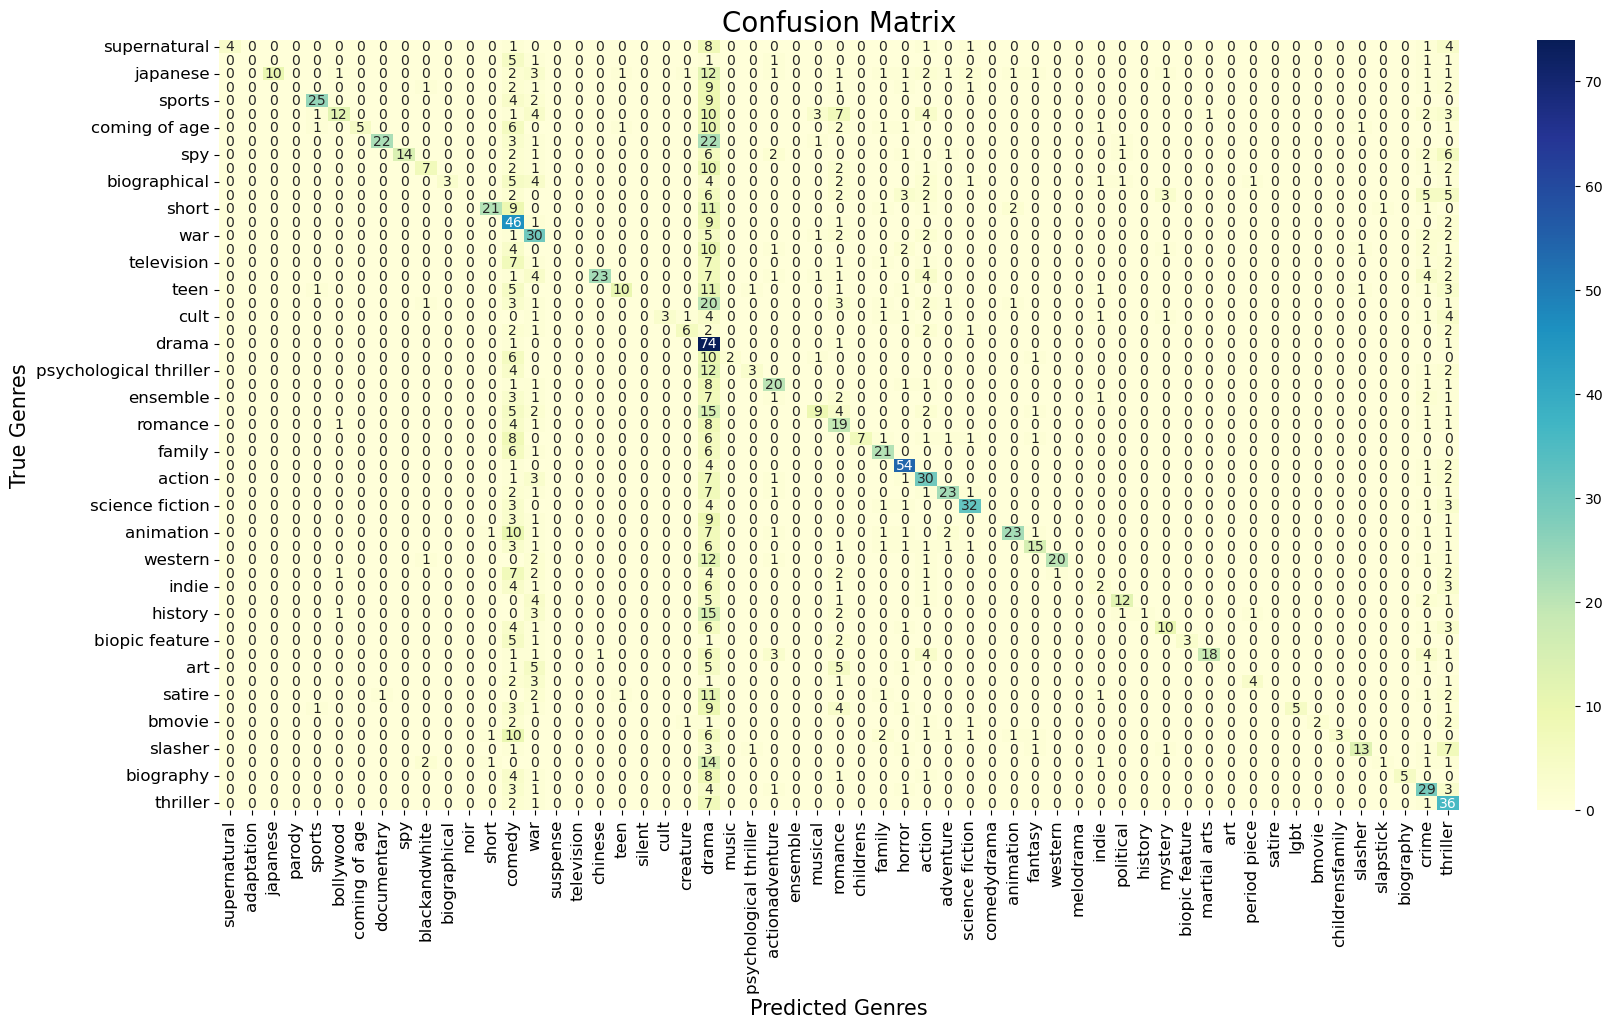

In [15]:
conf_mat,normal_conf_mat = mlcm.cm(label_true,label_pred,False)

one_vs_rest = mlcm.stats(conf_mat,False)

colnames = unique_genre + ['NPL']
rownames = unique_genre + ['NTL']


#make dataframe from confusion matrix
df_confusion = pd.DataFrame(normal_conf_mat, columns=colnames, index=rownames)
df_confusion.drop('NTL', inplace=True)
df_confusion.drop('NPL', axis=1, inplace=True)

#plot df_confusion
plt.figure(figsize = (20,10))
sns.heatmap(df_confusion, annot=True, cmap="YlGnBu")
plt.title('Confusion Matrix', fontsize=20)
plt.xlabel('Predicted Genres', fontsize=15)
plt.ylabel('True Genres', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

### Rest vs All plots

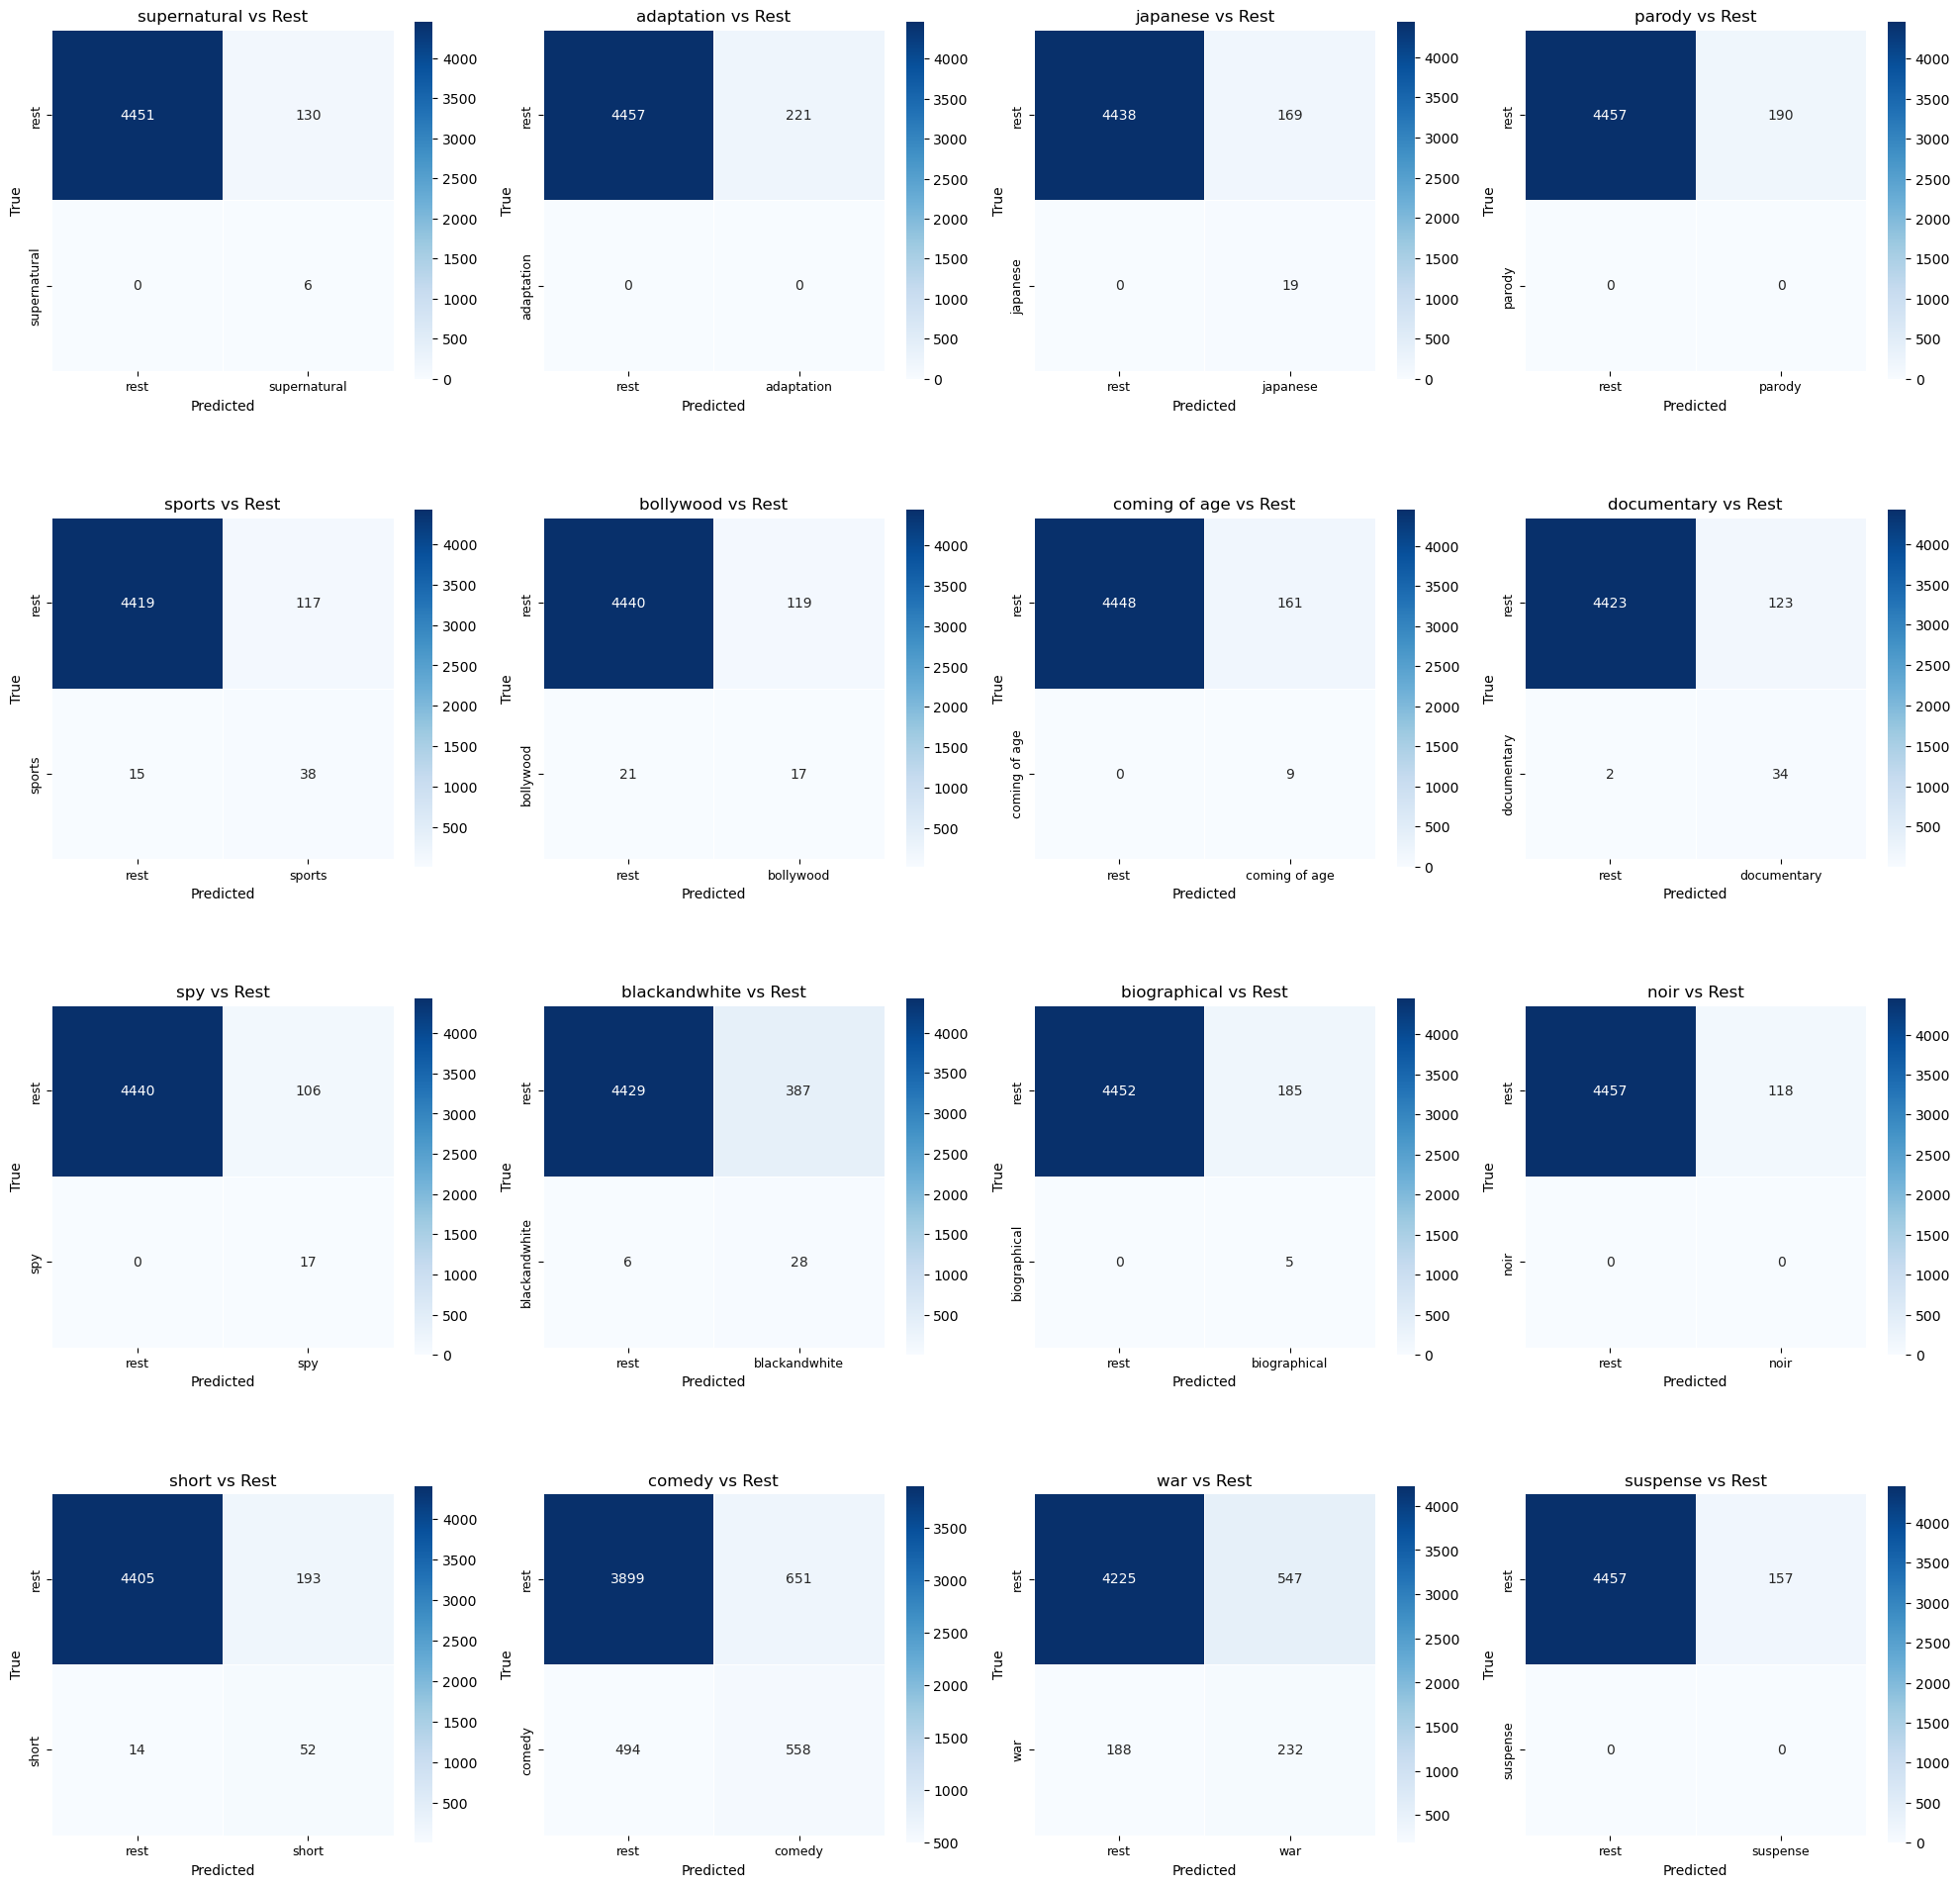

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(20, 20))

# Iterate over the first 16 genres
for i in range(16):  
    #column names
    colnames = ['rest', unique_genre[i]]
    
    #DataFrame
    df1 = pd.DataFrame(one_vs_rest[i], columns=colnames, index=['rest' , unique_genre[i]]).transpose()

    ax = plt.subplot(4, 4, i + 1)
    
    #heatmap
    sns.heatmap(df1, annot=True, fmt="d", cmap="Blues", square=True, linewidths=.5, cbar_kws={"shrink": .75})

    # Titles and labels
    ax.set_title(f'{unique_genre[i]} vs Rest', fontsize=12)
    ax.set_xlabel('Predicted', fontsize=10)
    ax.set_ylabel('True', fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=9)

plt.tight_layout()
plt.show()


Naive Bayes

In [ ]:
# do with naive bayes
from sklearn.naive_bayes import GaussianNB
from sklearn.multiclass import OneVsRestClassifier

# Create a classifier: a support vector classifier
classifier = OneVsRestClassifier(GaussianNB())

# Train the classifier on the training set
classifier.fit(xtrain_tfidf.toarray(), ytrain)

# Predict and evaluate
y_pred = classifier.predict(xval_tfidf.toarray())
print(classification_report(yval, y_pred))

# Sample predictions
def new_val(x):  
    x = remove_stopwords(clean_text(x))
    x_vec = tfidf_vect.transform([x])
    x_pred = classifier.predict(x_vec.toarray())
    return multilabel_bina.inverse_transform(x_pred)

In [ ]:
#write classification report to csv
report = classification_report(yval, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report.to_csv('Results\Metrics\classification_report_balanced_NB.csv', index=True, sep=';')

c:\Users\Gabriel\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
for i in range(5): 
    k = xval.sample(1).index[0] 
    print("Movie: ", df['title'][k], "\nPredicted genre: ", new_val(xval[k]))
    print("Actual genre: ",df['genre'][k], "\n")

Movie:  Ashes of Time 
Predicted genre:  [('actionadventure', 'adventure', 'chinese', 'crime', 'martial arts', 'period piece', 'romance', 'thriller', 'war')]
Actual genre:  ['adventure', 'period piece', 'martial arts', 'chinese'] 

Movie:  The Escort 
Predicted genre:  [('action', 'actionadventure', 'adaptation', 'adventure', 'blackandwhite', 'bollywood', 'comedy', 'crime', 'drama', 'family', 'fantasy', 'lgbt', 'musical', 'mystery', 'parody', 'period piece', 'political', 'romance', 'satire', 'suspense', 'thriller', 'war', 'western')]
Actual genre:  ['thriller', 'crime', 'war', 'actionadventure', 'political'] 

Movie:  Brian's Song 
Predicted genre:  [('biographical', 'biography', 'comedy', 'crime', 'drama', 'indie', 'period piece', 'science fiction', 'sports', 'teen', 'thriller')]
Actual genre:  ['sports', 'period piece', 'biography', 'drama'] 

Movie:  Blackmail 
Predicted genre:  [('action', 'actionadventure', 'adaptation', 'adventure', 'blackandwhite', 'comedy', 'comedydrama', 'crim

SVM

In [ ]:
#do state vector machine
import sklearn.svm as svm
from sklearn.multiclass import OneVsRestClassifier

# Create a classifier: a support vector classifier
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=0))

# Train the classifier on the training set
classifier.fit(xtrain_tfidf, ytrain)

# Predict and evaluate
y_pred = classifier.predict(xval_tfidf)
print(classification_report(yval, y_pred))

# Sample predictions
def new_val(x):  
    x = remove_stopwords(clean_text(x))
    x_vec = tfidf_vect.transform([x])
    x_pred = classifier.predict(x_vec)
    return multilabel_bina.inverse_transform(x_pred)

In [ ]:
#write classification report to csv
report = classification_report(yval, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report.to_csv('Results\Metrics\classification_report_balanced_SVM.csv', index=True, sep=';')

In [ ]:
for i in range(5): 
    k = xval.sample(1).index[0] 
    print("Movie: ", df['title'][k], "\nPredicted genre: ", new_val(xval[k]))
    print("Actual genre: ",df['genre'][k], "\n")